## Imports and functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import itertools
import ot
import glob
import os
from utils.utils import *

In [5]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
pairs = list(itertools.combinations(image_numbers, 2))

categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = glob.glob(categories_pattern)
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [53]:
def Fourier2(a, b, T=2*np.pi):
    pipi = 2 * np.pi
    m, n = np.shape(a)
    dxdy = (T / m) * (T / n)

    # Normalize a and b
    a /= np.sum(a)
    b /= np.sum(b)

    # Calculate expected values and translation vector efficiently
    valore_atteso_a = np.array([np.sum(a * np.arange(m)[:, None]), np.sum(a * np.arange(n))])
    valore_atteso_b = np.array([np.sum(b * np.arange(m)[:, None]), np.sum(b * np.arange(n))])
    vettore_traslazione = valore_atteso_b - valore_atteso_a

    # Perform FFT
    fa = np.fft.fft2(a)
    fb = np.fft.fft2(b)

    # Calculate distance considering the translation vector
    integrale = 0
    for y in range(n):
        for x in range(m):
            # Avoid division by zero for the zero frequency component
            if x == 0 and y == 0:
                continue
            freq_magnitude = np.sqrt(((x * pipi / m) ** 2) + ((y * pipi / n) ** 2))
            trasl = np.exp((2 * np.pi * 1j * vettore_traslazione[0] * x) / m) * np.exp(
                (2 * np.pi * 1j * vettore_traslazione[1] * y) / n)
            integrale += ((np.abs(fa[x, y] - fb[x, y] * trasl)) ** 2) / (freq_magnitude ** 4) * dxdy

    C = (((1 / T) ** 2) * 2 * integrale) ** (1 / 2)
    distanza = np.sqrt((C ** 2) + (np.sum(vettore_traslazione ** 2)))

    return distanza

In [54]:

def Fourier1(a, b, T=2 * np.pi):
    pipi = 2 * np.pi
    m, n = np.shape(a)
    dxdy = (T / m) * (T / n)

    # Normalize a and b
    a /= np.sum(a)
    b /= np.sum(b)

    # Perform FFT
    fa = np.fft.fft2(a)
    fb = np.fft.fft2(b)

    # Calculate distance using a single loop
    integrale = 0
    for y in range(n):
        for x in range(m):
            # Compute frequency magnitude (handling the zero frequency separately)
            if x == 0 and y == 0:
                continue  # Skip the zero frequency to avoid division by zero
            freq_magnitude = np.sqrt(((x * pipi / m) ** 2) + ((y * pipi / n) ** 2))
            
            # Increment integral
            integrale += ((np.abs(fa[x, y] - fb[x, y])) ** 2) / (freq_magnitude ** 2) * dxdy

    # Calculate final distance
    C = (((1 / T) ** 2) * 2 * integrale) ** (1 / 2)
    return C

In [55]:
def calculate_costs(size, distance_metric='L1'):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or tuple): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """

    # Helper function for L1 and L2 distance
    if distance_metric == 'L1':
        dist = lambda a, b: abs(a - b)
    elif distance_metric == 'L2':
        dist = lambda a, b: (a - b) ** 2
    else:
        raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

    # 1D case:
    if isinstance(size, int):
        X = np.linspace(0, 1, size)
        costs = np.zeros([size, size], np.float64)

        for it1 in range(size):
            for it2 in range(size):
                costs[it1, it2] = dist(X[it1], X[it2])

        return costs

    # 2D case:
    elif len(size) == 2:
        I, J = np.indices(size)
        
        # Flatten the indices to create 1D arrays of x and y coordinates
        I_flat = I.flatten()
        J_flat = J.flatten()
        
        # Calculate distances using broadcasting
        if distance_metric == 'L1':
            costs = np.abs(I_flat[:, None] - I_flat[None, :]) + np.abs(J_flat[:, None] - J_flat[None, :])
        elif distance_metric == 'L2':
            costs = np.sqrt((I_flat[:, None] - I_flat[None, :]) ** 2 + (J_flat[:, None] - J_flat[None, :]) ** 2)
        else:
            raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

        return costs

## Looking into the Cost matrices

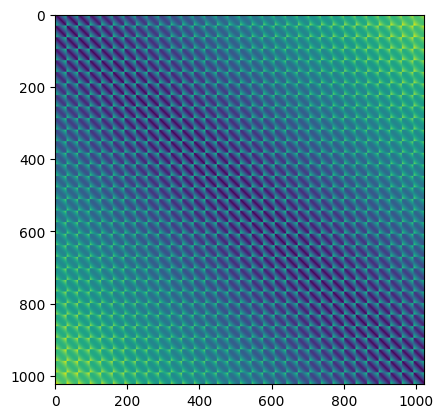

In [56]:
cost_matrix_l2 = calculate_costs((32,32), distance_metric = 'L2')
plt.imshow(cost_matrix_l2, cmap='viridis')

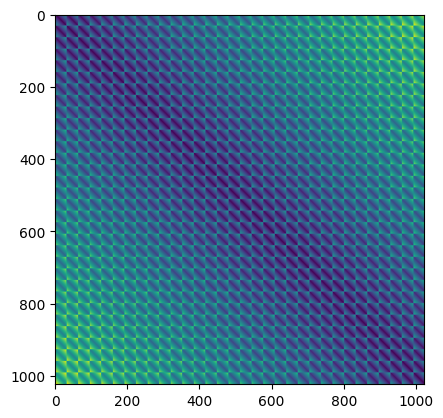

In [57]:
cost_matrix_l1 = calculate_costs((32,32), distance_metric = 'L1')
plt.imshow(cost_matrix_l1, cmap='viridis')

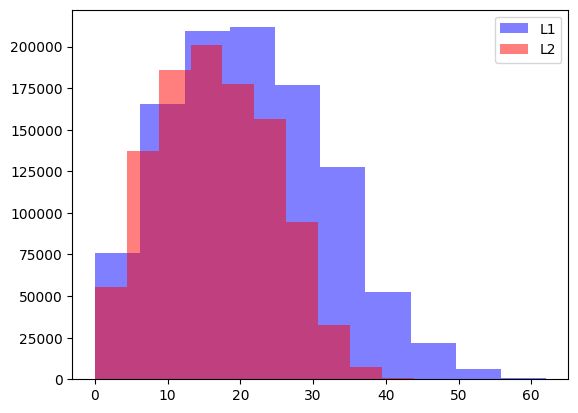

In [58]:
plt.hist(cost_matrix_l1.flatten(), alpha=0.5, label='L1', color='blue')
plt.hist(cost_matrix_l2.flatten(), alpha=0.5, label='L2', color='red')
plt.legend()
plt.show()

## Images, $W_2$ vs $f_{2,2}$

In [61]:
pfm_values_normal = []
pfm_values_shifted = []
w_values = []

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier2(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L2')
        w_dist = ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l2)
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

4.008510112762451 Time elapsed for Category CauchyDensity
6.5219128131866455 Time elapsed for Category ClassicImages
6.0401670932769775 Time elapsed for Category GRFmoderate
6.390498399734497 Time elapsed for Category GRFrough
6.349071979522705 Time elapsed for Category GRFsmooth
4.420593738555908 Time elapsed for Category LogGRF
5.215574026107788 Time elapsed for Category LogitGRF
2.9238531589508057 Time elapsed for Category MicroscopyImages
1.614091396331787 Time elapsed for Category Shapes
6.752189636230469 Time elapsed for Category WhiteNoise


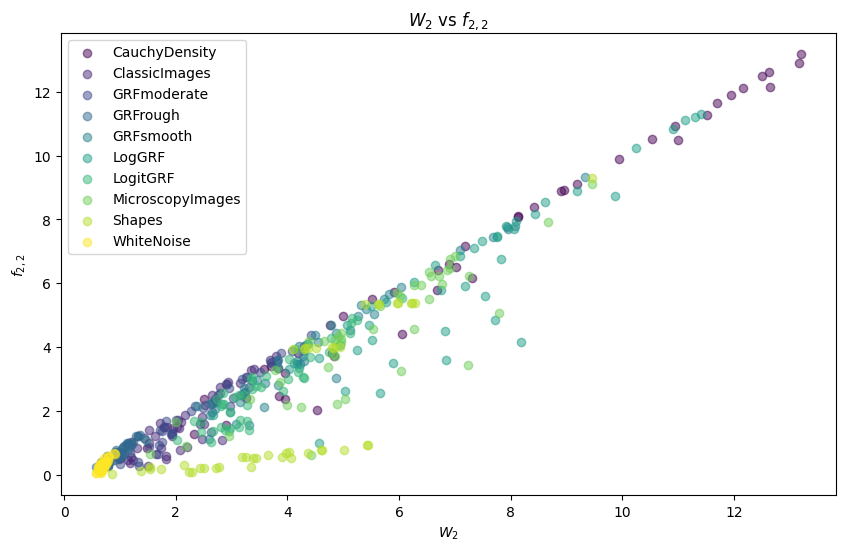

In [62]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(w_values[start:end], pfm_values_normal[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
plt.title('$W_2$ vs $f_{2,2}$')
plt.xlabel('$W_2$')
plt.ylabel('$f_{2,2}$')
plt.legend()
plt.show()

In [63]:
ratios = np.array(w_values) / np.array(pfm_values_normal)

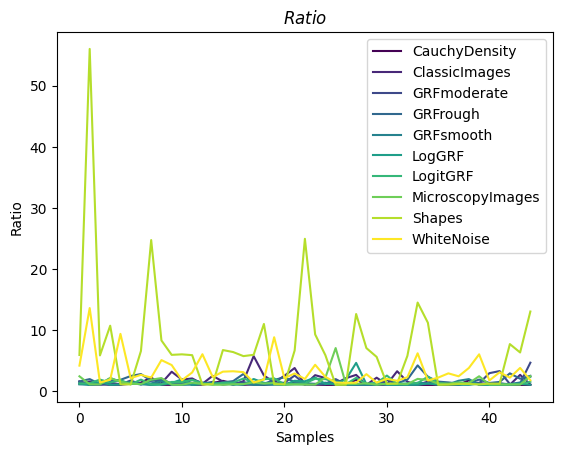

In [64]:
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()

## Images, $W_1$ vs $f_{1,2}$

In [129]:
pfm_values_normal = []
pfm_values_simplified = []
w_values = []

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier1(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L1')
        w_dist = ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l1)
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

4.284705877304077 Time elapsed for Category CauchyDensity
4.967988729476929 Time elapsed for Category ClassicImages
3.9423422813415527 Time elapsed for Category GRFmoderate
5.146664619445801 Time elapsed for Category GRFrough
3.7879908084869385 Time elapsed for Category GRFsmooth
3.2128384113311768 Time elapsed for Category LogGRF
3.9878737926483154 Time elapsed for Category LogitGRF
2.3002731800079346 Time elapsed for Category MicroscopyImages
1.3072609901428223 Time elapsed for Category Shapes
6.218838453292847 Time elapsed for Category WhiteNoise


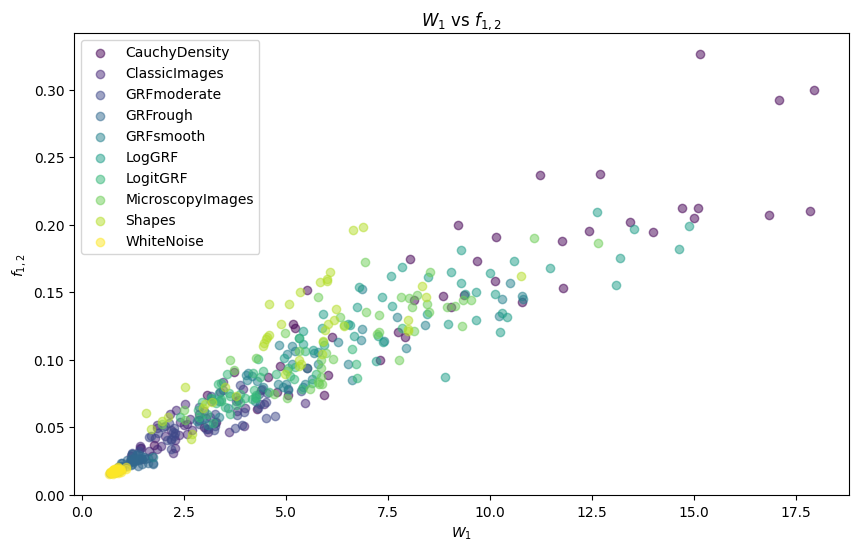

In [130]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(w_values[start:end], pfm_values_normal[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
plt.title('$W_1$ vs $f_{1,2}$')
plt.xlabel('$W_1$')
plt.ylabel('$f_{1,2}$')
plt.legend()
plt.show()

In [137]:
ratios = np.array(w_values) / np.array(pfm_values_normal)
# ratios = ratios / 32
# print(ratios.max())
# print(ratios.min())
# print(ratios.max() / ratios.min())

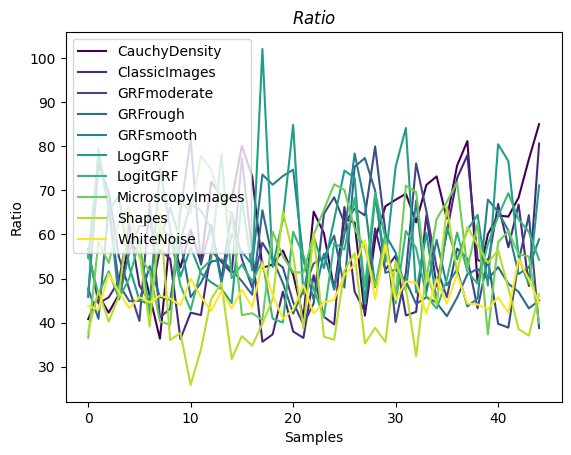

In [138]:
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()

## Other tryouts

### Single image, noising and looking at plots

In [139]:
category_names

['CauchyDensity',
 'ClassicImages',
 'GRFmoderate',
 'GRFrough',
 'GRFsmooth',
 'LogGRF',
 'LogitGRF',
 'MicroscopyImages',
 'Shapes',
 'WhiteNoise']

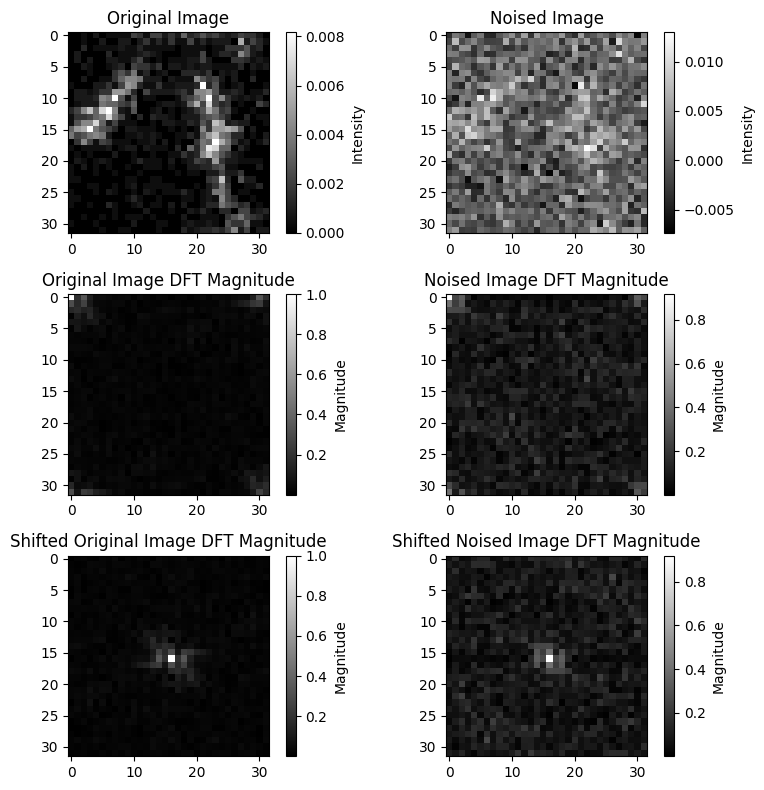

In [186]:
category_dir = os.path.join(full_path, 'MicroscopyImages')
path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
im1 = cv2.resize(im1, (resolution, resolution))
im1 = im1 / im1.sum()  # Normalize

# SNR = 10000  # Signal to noise ratio
# noise_param = noise_from_SNR(SNR, signal_power=im1.sum(), res=im1.shape[0])
noise_param = 3e-3
noise = np.random.normal(0, noise_param, im1.shape)
im1_noised = im1 + noise

# Compute the 2D FFT for both the original and noised images
DFT_coefficients_original = np.fft.fft2(im1)
DFT_coefficients_noised = np.fft.fft2(im1_noised)

# Compute the magnitude of the DFT coefficients for visualization
DFT_magnitude_original = np.abs(DFT_coefficients_original)
DFT_magnitude_noised = np.abs(DFT_coefficients_noised)

# Shift the zero frequency component to the center of the spectrum for visualization
DFT_magnitude_shifted_original = np.fft.fftshift(DFT_magnitude_original)
DFT_magnitude_shifted_noised = np.fft.fftshift(DFT_magnitude_noised)

# Plotting
plt.figure(figsize=(8, 8))

# Original Image
plt.subplot(3, 2, 1)
plt.imshow(im1, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Original Image')

# Noised Image
plt.subplot(3, 2, 2)
plt.imshow(im1_noised, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Noised Image')

# Original Image's DFT
plt.subplot(3, 2, 3)
plt.imshow(DFT_magnitude_original, cmap='gray', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.title('Original Image DFT Magnitude')

# Noised Image's DFT
plt.subplot(3, 2, 4)
plt.imshow(DFT_magnitude_noised, cmap='gray', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.title('Noised Image DFT Magnitude')

# Shifted Original Image's DFT
plt.subplot(3, 2, 5)
plt.imshow(DFT_magnitude_shifted_original, cmap='gray', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.title('Shifted Original Image DFT Magnitude')

# Shifted Noised Image's DFT
plt.subplot(3, 2, 6)
plt.imshow(DFT_magnitude_shifted_noised, cmap='gray', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.title('Shifted Noised Image DFT Magnitude')

plt.tight_layout()
plt.show()

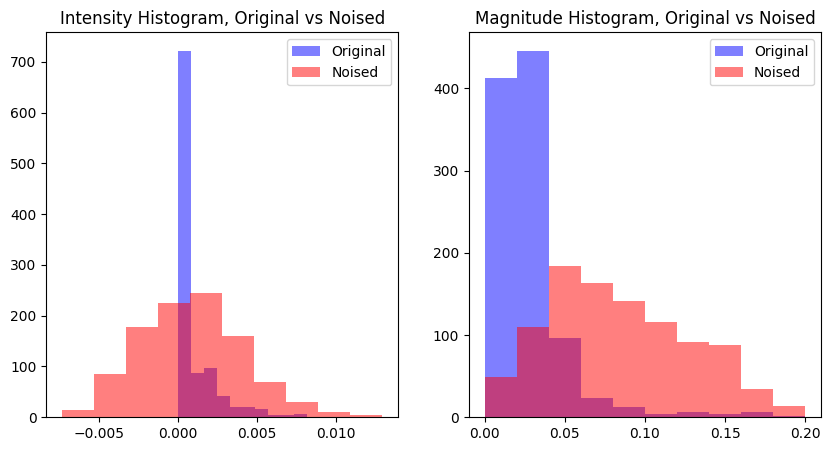

In [189]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(im1.flatten(), alpha=0.5, label='Original', color='blue')
plt.hist(im1_noised.flatten(), alpha=0.5, label='Noised', color='red')
plt.title('Intensity Histogram, Original vs Noised')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(DFT_magnitude_original.flatten(), alpha=0.5, label='Original', color='blue', range=(0, 0.2))
plt.hist(DFT_magnitude_noised.flatten(), alpha=0.5, label='Noised', color='red', range=(0, 0.2))
plt.title('Magnitude Histogram, Original vs Noised')
plt.legend()

plt.show()

In [191]:
DFT_magnitude_original

array([[1.        , 0.18711285, 0.33809167, ..., 0.12551662, 0.33809167,
        0.18711285],
       [0.30278918, 0.1607888 , 0.25775491, ..., 0.2083047 , 0.23293462,
        0.07835287],
       [0.14928909, 0.1780126 , 0.12949947, ..., 0.06961923, 0.0493574 ,
        0.04274447],
       ...,
       [0.01111081, 0.06870522, 0.01198813, ..., 0.16304428, 0.06261408,
        0.11793739],
       [0.14928909, 0.04274447, 0.0493574 , ..., 0.145814  , 0.12949947,
        0.1780126 ],
       [0.30278918, 0.07835287, 0.23293462, ..., 0.09784838, 0.25775491,
        0.1607888 ]])

Mean Delta: -0.059643659966115606
Std Delta: 0.048856528404445654


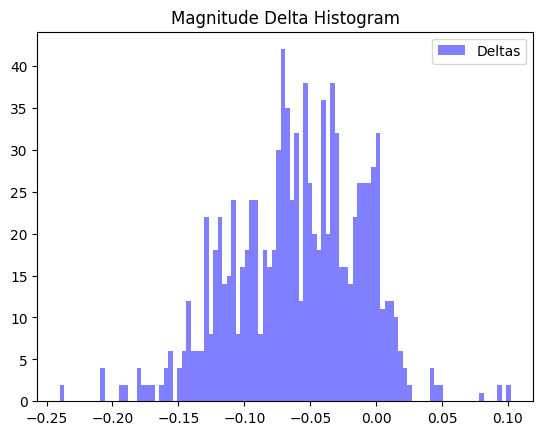

In [190]:
deltas = DFT_magnitude_original - DFT_magnitude_noised
print(f'Mean Delta: {np.mean(deltas)}')
print(f'Std Delta: {np.std(deltas)}')
plt.hist(deltas.flatten(), bins=100, alpha=0.5, label='Deltas', color='blue')
plt.title('Magnitude Delta Histogram')
plt.legend()
plt.show()

In [127]:
category_dir = os.path.join(full_path, 'ClassicImages')
path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_numbers[2]}.png")
im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
im1 = cv2.resize(im1, (resolution, resolution))
im1 = im1 / im1.sum()  # Normalize

num_experiments = 10000

delta_means = []
delta_stds = []

for i in range(num_experiments):
    noise_param = 1e-3
    noise = np.random.normal(0, noise_param, im1.shape)
    im1_noised = im1 + noise
    
    # Compute the 2D FFT for both the original and noised images
    DFT_coefficients_original = np.fft.fft2(im1)
    DFT_coefficients_noised = np.fft.fft2(im1_noised)
    # Compute the magnitude of the DFT coefficients for visualization
    DFT_magnitude_original = np.abs(DFT_coefficients_original)
    DFT_magnitude_noised = np.abs(DFT_coefficients_noised)
    # Shift the zero frequency component to the center of the spectrum for visualization
    DFT_magnitude_shifted_original = np.fft.fftshift(DFT_magnitude_original)
    DFT_magnitude_shifted_noised = np.fft.fftshift(DFT_magnitude_noised)

    deltas = DFT_magnitude_original - DFT_magnitude_noised
    delta_means.append(np.mean(deltas))
    delta_stds.append(np.std(deltas))

Mean Delta: -0.0220370832591985
Std Delta: 0.0006825007635971256
Mean Std Delta: 0.01632760147535694
Std Std Delta: 0.0005508074225383665


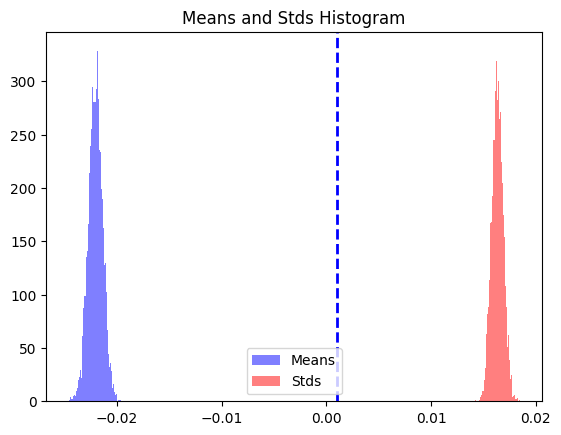

In [128]:
delta_means = np.array(delta_means)
delta_means_std = np.std(delta_means)
print(f'Mean Delta: {np.mean(delta_means)}')
print(f'Std Delta: {delta_means_std}')
delta_stds = np.array(delta_stds)
delta_stds_std = np.std(delta_stds)
print(f'Mean Std Delta: {np.mean(delta_stds)}')
print(f'Std Std Delta: {delta_stds_std}')

plt.hist(delta_means, bins=100, alpha=0.5, label='Means', color='blue')
plt.hist(delta_stds, bins=100, alpha=0.5, label='Stds', color='red')
plt.axvline(noise_param, color='blue', linestyle='dashed', linewidth=2)
plt.title('Means and Stds Histogram')
plt.legend()

### Going over all the images

In [175]:
means_mean = []
means_std = []
stds_mean = []
stds_std = []

num_experiments = 5000
noise_param = 1e-2

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image in image_numbers:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        
        noise = np.random.normal(0, noise_param, im1.shape)
        im1_noised = im1 + noise

        delta_means = []
        delta_stds = []

        for i in range(num_experiments):
            

            # Compute the 2D FFT for both the original and noised images
            DFT_coefficients_original = np.fft.fft2(im1)
            DFT_coefficients_noised = np.fft.fft2(im1_noised)
            # Compute the magnitude of the DFT coefficients for visualization
            DFT_magnitude_original = np.abs(DFT_coefficients_original)
            DFT_magnitude_noised = np.abs(DFT_coefficients_noised)
            # Shift the zero frequency component to the center of the spectrum for visualization
            DFT_magnitude_shifted_original = np.fft.fftshift(DFT_magnitude_original)
            DFT_magnitude_shifted_noised = np.fft.fftshift(DFT_magnitude_noised)

            deltas = DFT_magnitude_original - DFT_magnitude_noised
            delta_means.append(np.mean(deltas))
            delta_stds.append(np.std(deltas))

        delta_means_mean = np.mean(delta_means)
        delta_means_std = np.std(delta_means)

        delta_stds_mean = np.mean(delta_stds)
        delta_stds_std = np.std(delta_stds)

        means_mean.append(delta_means_mean)
        means_std.append(delta_means_std)
        stds_mean.append(delta_stds_mean)
        stds_std.append(delta_stds_std)
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

6.733417510986328 Time elapsed for Category CauchyDensity
5.473094940185547 Time elapsed for Category ClassicImages
5.660260200500488 Time elapsed for Category GRFmoderate
5.610691547393799 Time elapsed for Category GRFrough
5.750446557998657 Time elapsed for Category GRFsmooth
5.828982353210449 Time elapsed for Category LogGRF
5.687825441360474 Time elapsed for Category LogitGRF
5.714911699295044 Time elapsed for Category MicroscopyImages
5.545027256011963 Time elapsed for Category Shapes
5.750568389892578 Time elapsed for Category WhiteNoise


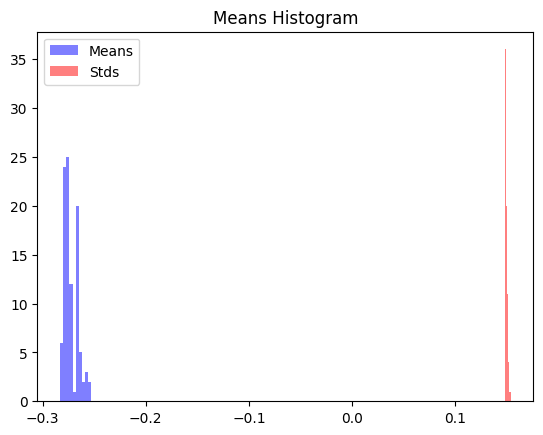

In [180]:
plt.hist(means_mean, alpha=0.5, label='Means', color='blue')
plt.hist(stds_mean, alpha=0.5, label='Stds', color='red')
plt.legend()
plt.title('Means Histogram')
plt.show()

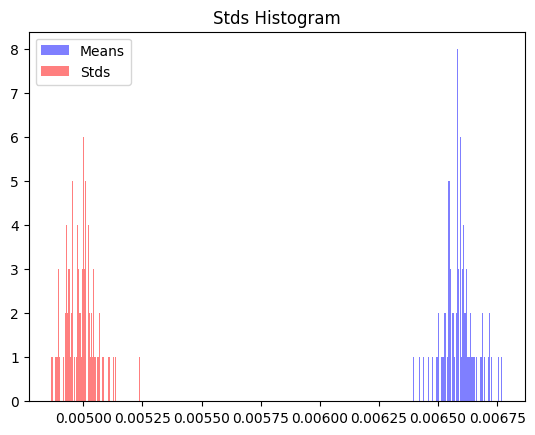

In [181]:
plt.hist(means_std, bins=100, alpha=0.5, label='Means', color='blue')
plt.hist(stds_std, bins=100, alpha=0.5, label='Stds', color='red')
plt.legend()
plt.title('Stds Histogram')
plt.show()

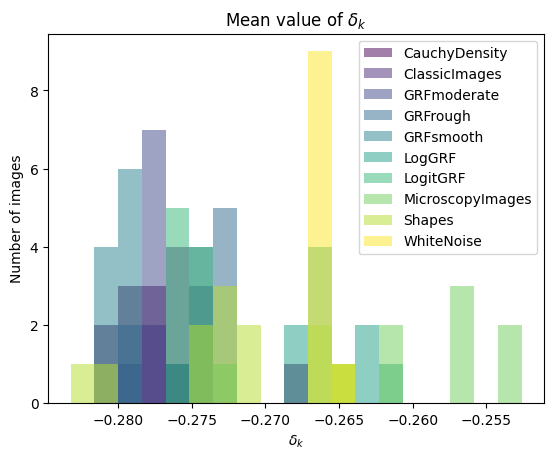

In [182]:
# Determine the overall range for all categories
all_values = np.concatenate([means_mean[i*10:(i+1)*10] for i in range(10)])
min_value = all_values.min()
max_value = all_values.max()

# Define common bins within the overall range
bins = np.linspace(min_value, max_value, 20) # Adjust the number 20 as needed

for i in range(10):
    start = i * 10
    end = (i + 1) * 10
    plt.hist(means_mean[start:end], bins=bins, color=colors[i], alpha=0.5, label=f'{category_names[i]}')

plt.xlabel('$\delta_{k}$')
plt.ylabel('Number of images')
plt.legend()
plt.title('Mean value of $\delta_{k}$')
plt.show()

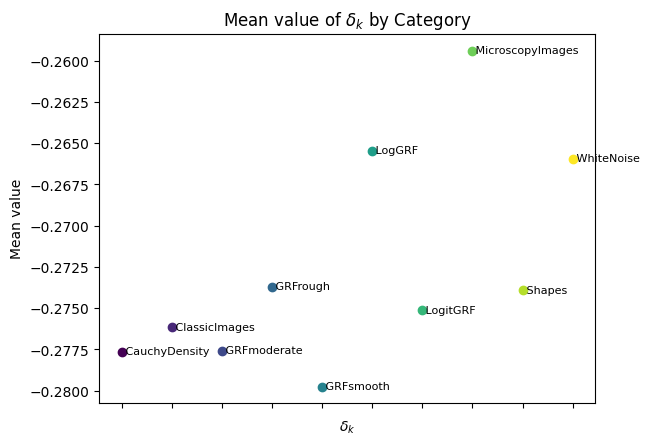

In [183]:
# Determine the overall range for all categories
all_values = np.concatenate([means_mean[i*10:(i+1)*10] for i in range(10)])
min_value = all_values.min()
max_value = all_values.max()

# Define common bins within the overall range
bins = np.linspace(min_value, max_value, 20) # Adjust the number 20 as needed
category_means = [np.mean(means_mean[i*10:(i+1)*10]) for i in range(10)]

for i, (mean, name) in enumerate(zip(category_means, category_names)):
    plt.scatter(i, mean, color=colors[i])  # Assume colors is defined
    plt.text(i, mean, f' {name}', va='center', ha='left', fontsize=8)

plt.xlabel('$\delta_{k}$')
plt.ylabel('Mean value')
plt.title('Mean value of $\delta_{k}$ by Category')
plt.xticks(range(len(category_names)), [])  # Hide x-axis labels if desired
plt.show()

In [146]:
print(f'Means Mean: {np.mean(means_mean)}')
print(f'Stds Mean: {np.mean(stds_mean)}')
print(f'Means Std: {np.mean(means_std)}')
print(f'Stds Std: {np.mean(stds_std)}')

Means Mean: -0.021105857826591436
Stds Mean: 0.016777498238588744
Means Std: 0.0007032241406514357
Stds Std: 0.0005595716910135169
